In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import logging

logging.getLogger('jieba').setLevel(logging.WARN)
logging.getLogger('fgclassifier').setLevel(logging.INFO)
logging.getLogger('fgclassifier.features').setLevel(logging.INFO)

In [2]:
import os

os.chdir('..')

In [3]:
from fgclassifier.utils import read_data, get_dataset

X_train, y_train = read_data(get_dataset('train_en'), flavor=None, sample_n=1000)
X_train.shape

2018-12-06 23:45:37,534 [INFO] Reading /opt/storage/english_train.csv..
2018-12-06 23:45:37,728 [INFO] Take 1000 samples with random state 1


(1000,)

Exam the usage of np.linspace/logspace

In [4]:
np.linspace(100, 1000, 10)

array([ 100.,  200.,  300.,  400.,  500.,  600.,  700.,  800.,  900.,
       1000.])

In [5]:
np.logspace(-4, 4, 9)

array([1.e-04, 1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03,
       1.e+04])

In [6]:
np.linspace(0, 1, 11)

array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ])

Build the features

In [7]:
from sklearn.pipeline import Pipeline
from fgclassifier.features import Count, Tfidf

2018-12-06 23:45:39,924 [INFO] 'pattern' package not found; tag filters are not available for English


## Optimize classifier 

We use TruncatedSVD for dimension reduction, then pass the reduced dataset
to LDA. This is more efficient as this way we can handle sparse matrix whereas
LDA requires dense matrix input.

In [10]:
from IPython.display import clear_output
from sklearn.model_selection import GridSearchCV
from sklearn.externals import joblib
from sklearn.decomposition import TruncatedSVD

from fgclassifier.baseline import Baseline, MultiOutputClassifier
from fgclassifier.classifiers import LinearDiscriminantAnalysis as LDA

In [ ]:
# Trial 1: tune number of components
clf = Pipeline([
    ('vect', Count(min_df=0.05, ngram_range=(1, 1))),
    ('tfidf', Tfidf()),
    ('svd', TruncatedSVD(n_components=250)),
    ('clf', MultiOutputClassifier(LDA()))
])

n_choices = np.linspace(50, 400, 15, dtype=int)
print(n_choices)
parameters = {
    'svd__n_components': n_choices
}

with joblib.parallel_backend('threading', n_jobs=3):
    searcher = GridSearchCV(
        clf, parameters, cv=5,
        verbose=True,
        return_train_score=True
    )
    display(searcher)
    searcher.fit(X_train, y_train)

clear_output()

In [13]:
# Trial 2: tune shrinkage
clf = Pipeline([
    ('vect', Count(min_df=0.05, ngram_range=(1, 1))),
    ('tfidf', Tfidf()),
    ('svd', TruncatedSVD(n_components=100)),
    ('clf', MultiOutputClassifier(LDA()))
])

parameters = {
    'clf__estimator__solver': ['lsqr', 'eigen'],
    'clf__estimator__shrinkage': [
        None, 'auto',
        0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
}

with joblib.parallel_backend('threading', n_jobs=3):
    searcher = GridSearchCV(
        clf, parameters, cv=5,
        verbose=True,
        return_train_score=True
    )
    display(searcher)
    searcher.fit(X_train, y_train)

clear_output()

In [14]:
searcher.best_estimator_

Pipeline(memory=None,
     steps=[('vect', Count(analyzer='word', binary=False, decode_error='strict',
   dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
   lowercase=True, max_df=1.0, max_features=None, min_df=0.05,
   ngram_range=(1, 1), preprocessor=None, stop_words=None,
   strip_accents=None, token_patter...ge=None,
              solver='lsqr', store_covariance=False, tol=0.0001),
           n_jobs=None))])

In [15]:
pd.DataFrame(searcher.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_clf__estimator__shrinkage,param_clf__estimator__solver,params,split0_test_score,split1_test_score,split2_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,1.248594,0.057886,0.269143,0.168666,None,lsqr,"{'clf__estimator__shrinkage': None, 'clf__esti...",0.338592,0.339504,0.336865,...,0.336961,0.012416,1,0.648185,0.646741,0.654156,0.646254,0.641806,0.647428,0.003982
1,1.448375,0.101296,0.191613,0.093597,None,eigen,"{'clf__estimator__shrinkage': None, 'clf__esti...",0.201613,0.206014,0.204162,...,0.206070,0.006589,17,0.201440,0.202081,0.201703,0.202195,0.200963,0.201676,0.000447
2,1.880322,0.078014,0.090845,0.010592,auto,lsqr,"{'clf__estimator__shrinkage': 'auto', 'clf__es...",0.309859,0.308398,0.314551,...,0.309782,0.015883,12,0.621167,0.623599,0.616338,0.616679,0.618148,0.619186,0.002788
3,2.599932,0.142600,0.109439,0.016294,auto,eigen,"{'clf__estimator__shrinkage': 'auto', 'clf__es...",0.201613,0.206014,0.204162,...,0.206136,0.006529,14,0.201440,0.202081,0.201703,0.202914,0.200963,0.201820,0.000657
4,1.449210,0.161419,0.128005,0.089928,0.1,lsqr,"{'clf__estimator__shrinkage': 0.1, 'clf__estim...",0.339138,0.338932,0.340781,...,0.336579,0.006471,2,0.649798,0.641795,0.642836,0.643990,0.642428,0.644169,0.002904
5,1.395027,0.117119,0.129430,0.089454,0.1,eigen,"{'clf__estimator__shrinkage': 0.1, 'clf__estim...",0.201613,0.206014,0.204162,...,0.206070,0.006589,17,0.201440,0.202081,0.201703,0.202195,0.200963,0.201676,0.000447
6,1.700930,0.247484,0.107141,0.016917,0.2,lsqr,"{'clf__estimator__shrinkage': 0.2, 'clf__estim...",0.332651,0.343125,0.335442,...,0.332404,0.007709,7,0.639558,0.631736,0.640512,0.642511,0.634100,0.637683,0.004075
7,2.333481,0.234092,0.102249,0.015662,0.2,eigen,"{'clf__estimator__shrinkage': 0.2, 'clf__estim...",0.201613,0.206014,0.204162,...,0.206070,0.006589,17,0.201440,0.202081,0.201703,0.202277,0.200963,0.201693,0.000467
8,2.010244,0.199863,0.097672,0.009663,0.3,lsqr,"{'clf__estimator__shrinkage': 0.3, 'clf__estim...",0.331467,0.336594,0.325614,...,0.331709,0.008646,8,0.636190,0.627833,0.632653,0.639089,0.638475,0.634848,0.004171
9,1.758062,0.113562,0.108878,0.023050,0.3,eigen,"{'clf__estimator__shrinkage': 0.3, 'clf__estim...",0.201613,0.206014,0.204162,...,0.206070,0.006589,17,0.201440,0.202081,0.201703,0.202439,0.200963,0.201725,0.000510


In [19]:
import seaborn as sns

def extract_results(searcher, params, params_rpl=None):
    """Process the results for display"""
    colnames = [f'param_{x}' for x in params]
    results =  pd.melt(
        pd.DataFrame(searcher.cv_results_),
        id_vars=colnames,
        value_vars=[
            'mean_test_score',
            'mean_train_score',
        ],
        value_name='score'
    )
    results.columns = (params_rpl or params) + ['variable', 'score']
    results['train_or_test'] = np.where(results['variable'].str.contains('test'),
                                        'test', 'train')
    results = results.drop(['variable'], axis=1)
    return results


In [22]:
# Trial 2: True Shrinkage
import seaborn as sns

sns.set(style="whitegrid")

results = extract_results(
    searcher,
    ['clf__estimator__shrinkage', 'clf__estimator__solver'],
    ['shrinkage', 'solver']
)
results.sample(5)

,shrinkage,solver,score,train_or_test
8,0.3,lsqr,0.331709,test
39,0.6,eigen,0.201806,train
27,auto,eigen,0.201820,train
17,0.7,eigen,0.206070,test
13,0.5,eigen,0.206070,test


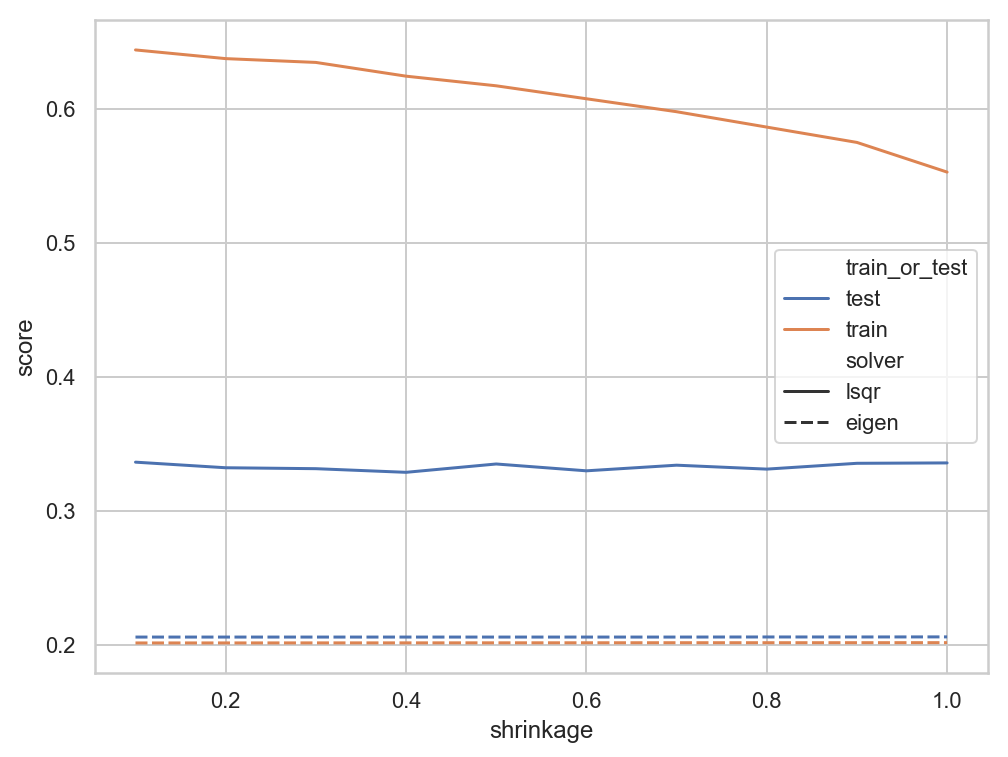

In [38]:
fig, ax = plt.subplots(figsize=(8, 6))

sns.lineplot(
    x='shrinkage',
    y='score',
    hue='train_or_test',
    style='solver',
    data=results[np.logical_not(results.shrinkage.isin((None, 'auto')))],
    ax=ax
)

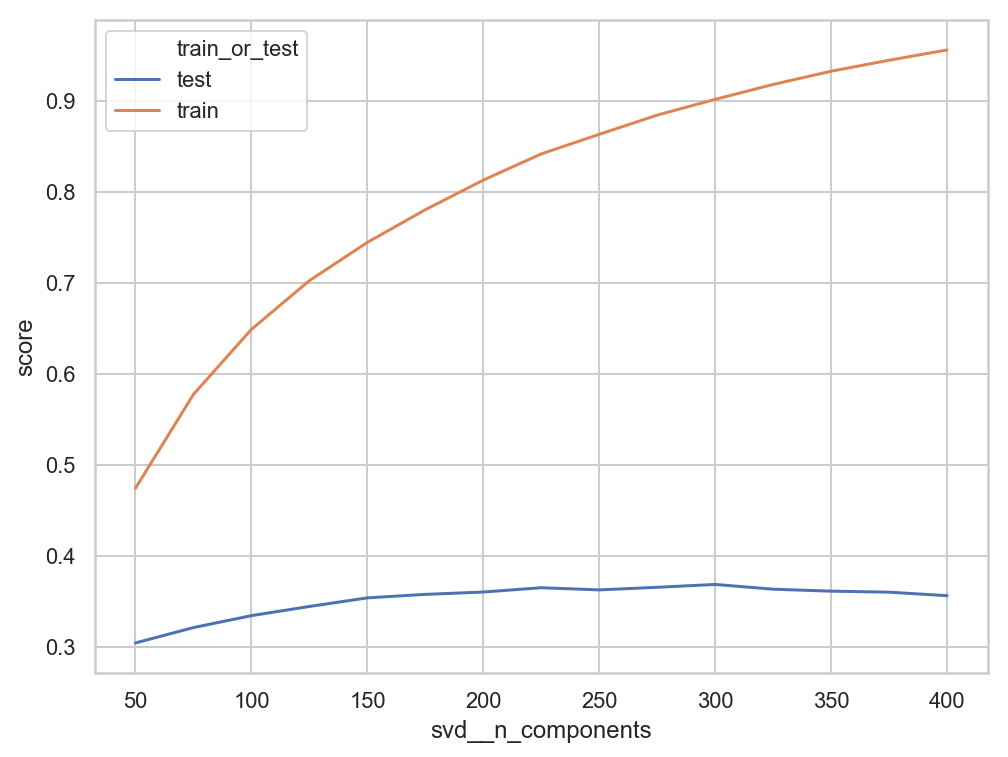

In [44]:
import seaborn as sns

sns.set(style="whitegrid")

fig, ax = plt.subplots(figsize=(8, 6))

results = extract_results(searcher, ['svd__n_components'])
results.head()
sns.lineplot(
    x='svd__n_components',
    y='score',
    hue='train_or_test',
    data=results,
    ax=ax
)

Looks like the LDA paramater does not matter for LDA.